In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import streamlit as st

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/50


I0000 00:00:1719857813.519061     119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


41/41 ━━━━━━━━━━━━━━━━━━━━ 58s 905ms/step - loss: 6.1949 - root_mean_squared_error: 2.3904 - val_loss: 1.1651 - val_root_mean_squared_error: 1.0794
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 503ms/step - loss: 1.5180 - root_mean_squared_error: 1.2319 - val_loss: 1.0700 - val_root_mean_squared_error: 1.0344
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 503ms/step - loss: 1.4975 - root_mean_squared_error: 1.2235 - val_loss: 1.0712 - val_root_mean_squared_error: 1.0350
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 503ms/step - loss: 1.2827 - root_mean_squared_error: 1.1321 - val_loss: 1.6973 - val_root_mean_squared_error: 1.3028
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 503ms/step - loss: 1.3618 - root_mean_squared_error: 1.1666 - val_loss: 1.9716 - val_root_mean_squared_error: 1.4041
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 503ms/step - loss: 1.1770 - root_mean_squared_error: 1.0848 - val_loss: 0.9772 - val_root_mean_squared_error: 0.9885
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 503ms/step - lo

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

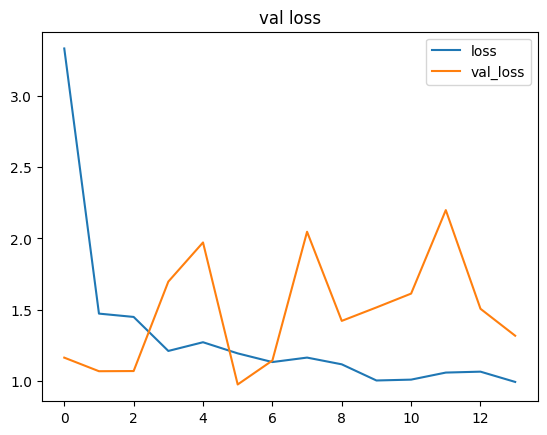

In [10]:
from transformers import TFBertModel, BertTokenizer
import tensorflow as tf

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

from tensorflow import keras
from tensorflow.keras import layers
from keras.metrics import RootMeanSquaredError

data = pd.read_csv("/kaggle/input/ielts-writing-scored-essays-dataset/ielts_writing_dataset.csv")
data.head()
data = data[data['Overall'].map(data['Overall'].value_counts()) > 1]

X = data["Essay"]
y = data["Overall"]

X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.1, shuffle=True, stratify=y, random_state=42)
X_train = bert_tokenizer(list(X_train), padding=True, truncation=True, return_tensors='tf', max_length = 512)['input_ids']
X_test = bert_tokenizer(list(X_test), padding=True, truncation=True, return_tensors='tf', max_length = 512)['input_ids']

reg = keras.Sequential([
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='softplus')
])
from tensorflow.keras.layers import Layer

class TFBertModelWrapper(Layer):
    def __init__(self, **kwargs):
        super(TFBertModelWrapper, self).__init__(**kwargs)
        self.bert_model = TFBertModel.from_pretrained('bert-base-uncased')

    def call(self, input_ids, attention_mask=None, token_type_ids=None, **kwargs):
        outputs = self.bert_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            **kwargs
        )
        return outputs[0]

input_ids = keras.layers.Input(shape=(512,), dtype=tf.int32)

output = TFBertModelWrapper()(input_ids)
pooling = output[:, 0, :]
output_ids = reg(pooling)

model = keras.Model(inputs = input_ids, outputs = output_ids)
for layer in bert_model.layers:
    layer.trainable = False

model.compile(optimizer = "adam",
             loss = "mean_squared_error",
             metrics = [RootMeanSquaredError()])

early_stopping = keras.callbacks.EarlyStopping(
    patience=8,
    min_delta=0,
    monitor = "val_loss",
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping],
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="val loss")



In [13]:
data = pd.read_csv("/kaggle/input/ielts-writing-scored-essays-dataset/ielts_writing_dataset.csv")
data.head()
data = data[["Task_Type", "Question", "Essay", "Overall"]]
X = np.array(data["Essay"])
y = np.array(data["Overall"])

Vectorizer = TfidfVectorizer()
X = Vectorizer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_1 = LinearRegression()
model_2 = SVR(kernel = "rbf", C = 1.0, epsilon = 0.1)
model_3 = RandomForestRegressor(n_estimators = 100, random_state = 42)

model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)

print("Linear Regression Score:",round(model_1.score(X_test, y_test) * 100,2), "%")
print("Support Vector Score:", round(model_2.score(X_test, y_test) * 100,2), "%")
print("Random Forest Score:", round(model_3.score(X_test, y_test) * 100,2), "%")

y_1 = model_1.predict(X_test)
y_2 = model_2.predict(X_test)
y_3 = model_3.predict(X_test)

print("R2 Score of Linear Regression =", round(r2_score(y_test, y_1), 2))
print("R2 Score of SVR =", round(r2_score(y_test, y_2), 2))
print("R2 Score of Random Forest =", round(r2_score(y_test, y_3), 2))

Linear Regression Score: 16.19 %
Support Vector Score: 22.57 %
Random Forest Score: 25.16 %
R2 Score of Linear Regression = 0.16
R2 Score of SVR = 0.23
R2 Score of Random Forest = 0.25


In [11]:
def round_to_nearest_half(num):
  return round(num * 2) /2

# Use best model (BERT)
count = 0
def main():
    global count
    st.title("Grade Your IELTS!")
    st.write("Please enter your essay to start grading.")

    count += 1
    user_input = st.text_input("You:", key=f"user_input_{count}")

    if user_input:
        new_input_ids = bert_tokenizer(user_input, padding=True, truncation=True, return_tensors='tf', max_length=512)['input_ids']
        response = model.predict(new_input_ids)
        st.text_area("Your score:", value=round_to_nearest_half(response), height=101, max_chars=None, key=f"chatbot_response_{count}")
        st.write("Thank you!")
        st.stop()

if __name__ == '__main__':
    main()

2024-07-01 19:08:03.151 
  command:

    streamlit run /opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-07-01 19:08:03.153 Session state does not function when running a script without `streamlit run`
